## <b>TEMA:</b> Identification of foliar diseases in apple trees using the teacher-student methodology under the self-training paradigm

<b>Autor:</b> Alex Darío Limaico Ortega <br>
<b>Director:</b> José Gabriel Garcial Pardo <br>

## Enunciado

En este TFM se pretenden aplicar técnicas de “self-training” bajo el paradigma “teacher-student” para entrenar modelos más robustos haciendo uso de datos no etiquetados a nivel de clase. Dicha metodología se basa en utilizar el conjunto de datos anotado para entrenar de manera supervisada un primer modelo (teacher), que predecirá las etiquetas de otro conjunto de datos no anotado. En base a los resultados de predicción, se definirán las etiquetas (conocidas como “pseudolabels”) de los datos no supervisados. Finalmente, un segundo modelo (student) será entrenado a partir de la información contenida en los dos conjuntos de datos (uno anotado y otro pseudo anotado) bajo la hipótesis de obtener un mejor rendimiento que solo utilizando el conjunto de datos etiquetado. Es decir, el alumno ha de comparar el rendimiento de los modelos Teacher y Student en la etapa de predicción del conjunto de test. Además, se propone el desarrollo de un modelo convencional fully supervised que funcione como “upper bound” para analizar cuán importante es el número de muestras etiquetadas en el rendimiento de los modelos predictivos para la tarea en cuestión.
Los algoritmos pertinentes serán desarrollados para abordar una tarea de clasificación multiclase donde el alumno tendrá que conseguir los mejores resultados posibles a la hora de distinguir entre hojas sanas, enfermas, con óxido o con costra.
Para ello, se hará uso de un repositorio público de imágenes plantas que contiene hojas de árboles de manzana.

Plant Pathology 2020 - FGVC7. Identify the category of foliar diseases in apple
trees. https://www.kaggle.com/c/plant-pathology-2020-fgvc7

# Desarrollo de modelos Teacher

## Carga de datos

In [2]:
import os
import zipfile

!kaggle --version

Kaggle API 1.5.12


In [2]:
# Descargando competencia
!kaggle competitions download -c plant-pathology-2020-fgvc7

plant-pathology-2020-fgvc7.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
try:
    os.mkdir("my_dataset")           # Directorio para descomprimir los datos
except:
    pass

# Descomprimimos los datos y los dejamos listos para trabajar
if len(os.listdir("my_dataset")) == 0:
    print("descomprimiendo dataset ..")
    with zipfile.ZipFile("plant-pathology-2020-fgvc7.zip","r") as zip_ref:
        zip_ref.extractall("my_dataset")
else:    
    print("Ya se ha descargado antes")

Ya se ha descargado antes


## Ordenación de datos

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras import  backend as K
from tensorflow.keras.models import load_model
# Clases
from utils import CreateEnvironment, ModDataFrame, ObtenerEtiquetas, SortEnvironment
from utils import InspecTrain_img, Plot_training_performance 
from preprocImage import PreprocData
from cnn import ConvNeuralNetwork

In [2]:
pathBase = "my_dataset/"          # Directorio de data

CreateEnvironment(pathBase)      # Renombrar, crear carpeta de test y separar train
pathTrain=pathBase+'train/'      # Directorio de train

# Leer data frame de train
df = pd.read_csv(pathBase + '/train.csv')        
display(df.head(4))

print("data frame modificado")
df_train = ModDataFrame(df)
display(df_train.head(4))

etiquetas = ObtenerEtiquetas(df_train)

renombrando carpeta de train ...
creando carpeta de noEtiquetadas ...
los archivos ya han sido movidos
Creando carpetas para guardar modelos ...


,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0


data frame modificado


,image_id,label
0,Train_0,costra
1,Train_1,multiples_enfermedades
2,Train_2,saludable
3,Train_3,oxido



Etiquetas de train
['costra', 'multiples_enfermedades', 'oxido', 'saludable']


In [7]:
# organizar datos de train segun su categoria
SortEnvironment(df_train,etiquetas,pathTrain)

creando sub carpetas ...
creando sub carpetas ...
creando sub carpetas ...
creando sub carpetas ...


## Inspección de datos

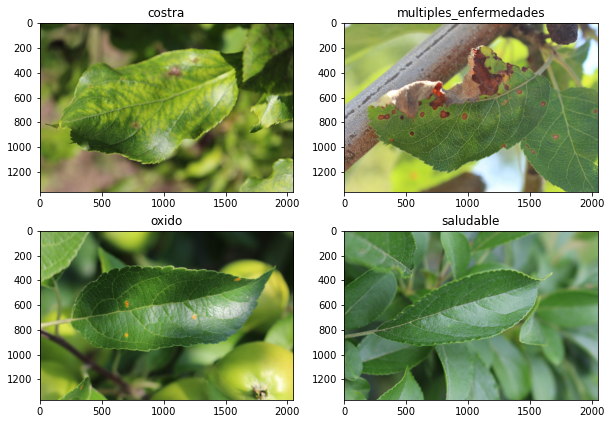

Numero de imagenes: 1821
Tamaño mínimo: [1365 1365]

Archivos por carpeta:

costra: 592
multiples_enfermedades: 91
oxido: 622
saludable: 516


In [3]:
# mostrar imagenes de ejemplo y obtener el numero de elementos
numImages, n_files = InspecTrain_img(etiquetas,pathTrain)

## Preprocesamiento de datos

In [4]:
batchSize = numImages
# targetSize = 128,128
targetSize = 192,192

dataTrain_teacher = PreprocData(batchSize,targetSize,pathTrain)  #Objeto para generacion de datos de train y test

# Llamada a función que devuelve data de train y test seárados (segun valSplit) 
# se guardara estos datos de TEST hasta el final durante todo el proceso
dataX, dataY, testX, testY = dataTrain_teacher.trainTest_dataGenerator(rotation=10,
                                                                       rescale=1./255,
                                                                       shear=0.1,
                                                                       zoom=0.1,
                                                                       flip_H=True,
                                                                       valSplit=0.2,  # 20% separado para TEST
                                                                       classMode = 'categorical',                                                                       
                                                                       labelNames = None)

Found 1458 images belonging to 4 classes.
Found 363 images belonging to 4 classes.
Forma de Datos de train
X: (1458, 192, 192, 3) y: (1458, 4)
Forma de Datos de validation
X: (363, 192, 192, 3) y: (363, 4)


## Arquitectura de red Neuronal

In [5]:
# direcciones para guardar modelos e imagenes
pathTeacher_models = "models/teacherModels/models"
pathTeacher_img = "models/teacherModels/img"

### Arquitectura 1

In [7]:
inputShape_train = dataTrain_teacher.get_dataShape()

K.clear_session() 

'''
Estructuras de clase

CapaInicial: (filters,kernels,activation)
BuildCapa: (filters,kernels,capas,activ,regularizer,valorRegularizer)
AddComplemento: (batchNormalization,dropout,dropVal,maxPooling,strides)
BuildTopModel: (flatten,filters,activation,regularizer,valorRegularizer)
ModelOutput: (activation)
'''

cnn = ConvNeuralNetwork(inputShape_train,len(etiquetas))  # Objeto CNN
cnn.CapaInicial(32,(3,3),'relu')                          # Primer set
cnn.AddComplemento(False,False,0,True,(2,2))     
cnn.BuildCapa(64,(3,3),1,'relu','_',0)                    # segundo set
cnn.AddComplemento(False,False,0,True,(2,2))
cnn.BuildCapa(128,(3,3),1,'relu','_',0)                   # tercer set
cnn.AddComplemento(False,False,0,True,(2,2))
cnn.BuildTopModel(True,256,'relu','_',0)                  # top model
cnn.AddComplemento(False,False,0,False,(1,1))
cnn.ModelOutput('softmax')
model = cnn.__get__()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 192, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0

In [8]:
cnn.Compile(0.001,"categorical_crossentropy")
epochs = 20
batchSize = 8

# Atributos de clase Train: (X,Y,valSplit,epochs,batchSize)
# Entrenamiento usando 20% de datos de TRAIN como validation (0.2) y 80% como TEST para training
H = cnn.Train(dataX,dataY,0.2,epochs,batchSize)

[INFO]: Compilando el modelo...
[INFO]: Entrenando la red...
Epoch 1/20
146/146 [==============================] - 31s 208ms/step - loss: 1.3170 - accuracy: 0.3190 - val_loss: 1.2406 - val_accuracy: 0.3356
Epoch 2/20
146/146 [==============================] - 30s 208ms/step - loss: 1.2505 - accuracy: 0.3439 - val_loss: 1.2305 - val_accuracy: 0.3801
Epoch 3/20
146/146 [==============================] - 30s 208ms/step - loss: 1.2428 - accuracy: 0.3636 - val_loss: 1.3573 - val_accuracy: 0.2979
Epoch 4/20
146/146 [==============================] - 30s 208ms/step - loss: 1.2101 - accuracy: 0.4091 - val_loss: 1.2215 - val_accuracy: 0.3767
Epoch 5/20
146/146 [==============================] - 30s 208ms/step - loss: 1.1230 - accuracy: 0.4991 - val_loss: 1.2440 - val_accuracy: 0.4247
Epoch 6/20
146/146 [==============================] - 30s 208ms/step - loss: 0.9725 - accuracy: 0.5746 - val_loss: 1.2892 - val_accuracy: 0.4384
Epoch 7/20
146/146 [==============================] - 30s 209ms/step 

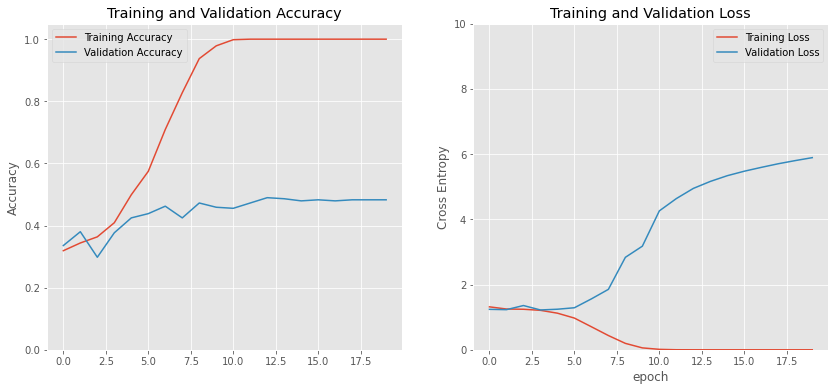

                        precision    recall  f1-score   support

                costra       0.57      0.57      0.57       118
multiples_enfermedades       0.00      0.00      0.00        18
                 oxido       0.43      0.48      0.45       124
             saludable       0.43      0.45      0.44       103

              accuracy                           0.47       363
             macro avg       0.36      0.37      0.37       363
          weighted avg       0.46      0.47      0.46       363



In [9]:
Plot_training_performance(H, epochs, pathTeacher_img+'/arq1')
cnn.Show_classification_report(testX, testY, batchSize, etiquetas)

### Arquitectura 2

In [8]:
inputShape_train = dataTrain_teacher.get_dataShape()
K.clear_session() 

cnn2 = ConvNeuralNetwork(inputShape_train,len(etiquetas))   # Objeto CNN
cnn2.CapaInicial(32,(3,3),'relu')                           # primer set
cnn2.AddComplemento(True,True,0.25,True,(2,2))     
cnn2.BuildCapa(64,(3,3),1,'relu','_',0)                     # segundo set
cnn2.AddComplemento(True,True,0.25,True,(2,2))
cnn2.BuildCapa(128,(3,3),1,'relu','_',0)                    # tercer set
cnn2.AddComplemento(True,True,0.25,True,(2,2))
cnn2.BuildTopModel(True,256,'relu','_',0)                  # top model
cnn2.AddComplemento(True,True,0.5,False,(1,1))
cnn2.ModelOutput('softmax')
model2 = cnn2.__get__()
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 192, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 192, 192, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0

In [11]:
cnn2.Compile(0.001,"categorical_crossentropy")
epochs = 20
batchSize = 8

# Entrenamiento usando 20% de datos de TRAIN como validation (0.2) y 80% como TEST para training
H2 = cnn2.Train(dataX,dataY,0.2,epochs,batchSize)

[INFO]: Compilando el modelo...
[INFO]: Entrenando la red...
Epoch 1/20
146/146 [==============================] - 44s 296ms/step - loss: 1.8747 - accuracy: 0.3370 - val_loss: 9.2113 - val_accuracy: 0.2740
Epoch 2/20
146/146 [==============================] - 43s 295ms/step - loss: 1.5128 - accuracy: 0.4151 - val_loss: 3.6117 - val_accuracy: 0.0548
Epoch 3/20
146/146 [==============================] - 43s 296ms/step - loss: 1.3770 - accuracy: 0.4425 - val_loss: 1.9463 - val_accuracy: 0.3288
Epoch 4/20
146/146 [==============================] - 43s 297ms/step - loss: 1.2572 - accuracy: 0.4751 - val_loss: 2.0654 - val_accuracy: 0.3390
Epoch 5/20
146/146 [==============================] - 45s 311ms/step - loss: 1.1321 - accuracy: 0.5223 - val_loss: 1.2500 - val_accuracy: 0.4315
Epoch 6/20
146/146 [==============================] - 44s 300ms/step - loss: 1.0930 - accuracy: 0.5360 - val_loss: 2.3376 - val_accuracy: 0.3219
Epoch 7/20
146/146 [==============================] - 44s 300ms/step 

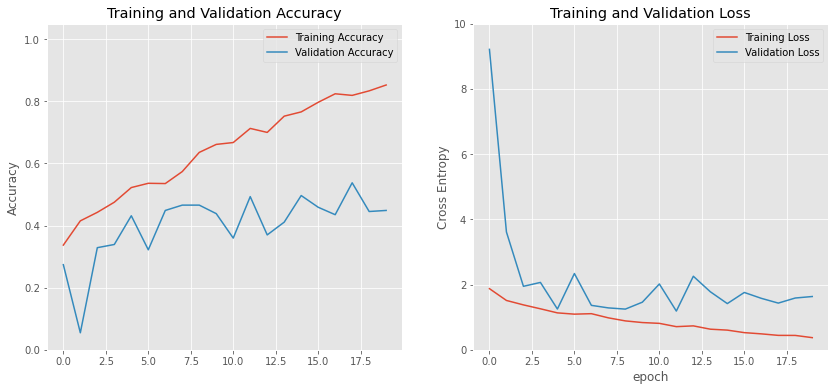

                        precision    recall  f1-score   support

                costra       0.46      0.86      0.60       118
multiples_enfermedades       0.00      0.00      0.00        18
                 oxido       0.72      0.31      0.43       124
             saludable       0.57      0.49      0.52       103

              accuracy                           0.52       363
             macro avg       0.44      0.41      0.39       363
          weighted avg       0.56      0.52      0.49       363



In [12]:
Plot_training_performance(H2, epochs, pathTeacher_img+'/arq2')
cnn2.Show_classification_report(testX, testY, batchSize, etiquetas)

### Arquitectura 3

In [14]:
inputShape_train = dataTrain_teacher.get_dataShape()
K.clear_session() 

cnn3 = ConvNeuralNetwork(inputShape_train,len(etiquetas))   # Objeto CNN
cnn3.CapaInicial(32,(3,3),'relu')                           # primer set
cnn3.AddComplemento(True,True,0.25,True,(2,2))     
cnn3.BuildCapa(64,(3,3),2,'relu','_',0)                     # segundo set
cnn3.AddComplemento(True,True,0.25,True,(2,2))     
cnn3.BuildCapa(128,(3,3),2,'relu','_',0)                    # tercer set
cnn3.AddComplemento(True,True,0.25,True,(2,2))     
cnn3.BuildTopModel(True,1024,'relu','_',0)                  # top model
cnn3.AddComplemento(True,True,0.5,False,(1,1))
cnn3.BuildTopModel(False,516,'relu','_',0)                       
cnn3.AddComplemento(True,True,0.5,False,(1,1))
cnn3.ModelOutput('softmax')
model3 = cnn3.__get__()
model3.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 192, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 192, 192, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 64)        2

In [15]:
cnn3.Compile(0.001,"categorical_crossentropy")
epochs = 20
batchSize = 8

# Entrenamiento usando 20% de datos de TRAIN como validation (0.2) y 80% como TEST para training
H3 = cnn3.Train(dataX,dataY,0.2,epochs,batchSize)

[INFO]: Compilando el modelo...
[INFO]: Entrenando la red...
Epoch 1/20
146/146 [==============================] - 97s 659ms/step - loss: 2.2541 - accuracy: 0.3242 - val_loss: 5.3141 - val_accuracy: 0.2945
Epoch 2/20
146/146 [==============================] - 96s 655ms/step - loss: 1.7297 - accuracy: 0.3679 - val_loss: 2.5501 - val_accuracy: 0.0890
Epoch 3/20
146/146 [==============================] - 96s 660ms/step - loss: 1.4858 - accuracy: 0.4185 - val_loss: 1.9666 - val_accuracy: 0.3185
Epoch 4/20
146/146 [==============================] - 96s 659ms/step - loss: 1.4526 - accuracy: 0.4048 - val_loss: 1.2978 - val_accuracy: 0.3938
Epoch 5/20
146/146 [==============================] - 96s 658ms/step - loss: 1.3768 - accuracy: 0.4297 - val_loss: 1.3619 - val_accuracy: 0.3973
Epoch 6/20
146/146 [==============================] - 96s 658ms/step - loss: 1.2491 - accuracy: 0.5017 - val_loss: 1.2911 - val_accuracy: 0.3801
Epoch 7/20
146/146 [==============================] - 96s 660ms/step 

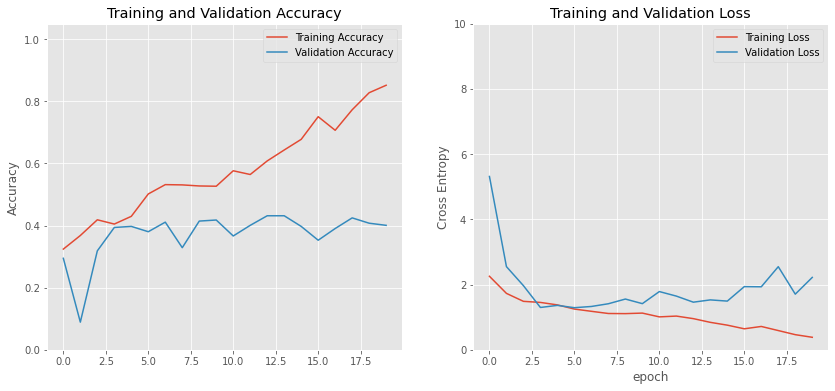

                        precision    recall  f1-score   support

                costra       0.48      0.64      0.55       118
multiples_enfermedades       0.00      0.00      0.00        18
                 oxido       0.42      0.32      0.36       124
             saludable       0.42      0.41      0.41       103

              accuracy                           0.43       363
             macro avg       0.33      0.34      0.33       363
          weighted avg       0.42      0.43      0.42       363



In [16]:
Plot_training_performance(H3, epochs, pathTeacher_img+'/arq3')
cnn3.Show_classification_report(testX, testY, batchSize, etiquetas)

### Arquitectura 4

In [11]:
inputShape_train = dataTrain_teacher.get_dataShape()
K.clear_session() 

cnn4 = ConvNeuralNetwork(inputShape_train,len(etiquetas))   # Objeto CNN
cnn4.CapaInicial(32,(3,3),'relu')                           # primer set
cnn4.AddComplemento(True,True,0.25,True,(2,2))     
cnn4.BuildCapa(64,(3,3),3,'relu','_',0)                     # segundo set
cnn4.AddComplemento(True,True,0.25,True,(2,2))     
cnn4.BuildCapa(128,(3,3),3,'relu','_',0)                    # tercer set
cnn4.AddComplemento(True,True,0.25,True,(2,2))     
cnn4.BuildTopModel(True,1024,'relu','_',0)                  # top model
cnn4.AddComplemento(True,True,0.5,False,(1,1))
cnn4.BuildTopModel(False,516,'relu','_',0)                       
cnn4.AddComplemento(True,True,0.5,False,(1,1))
cnn4.ModelOutput('softmax')
model4 = cnn4.__get__()
model4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 192, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 192, 192, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 96, 64)        3

In [17]:
cnn4.Compile(0.001,"categorical_crossentropy")
epochs = 20
batchSize = 8

# Entrenamiento usando 20% de datos de TRAIN como validation (0.2) y 80% como TEST para training
H4 = cnn4.Train(dataX,dataY,0.2,epochs,batchSize)

[INFO]: Compilando el modelo...
[INFO]: Entrenando la red...
Epoch 1/20
146/146 [==============================] - 119s 807ms/step - loss: 2.2047 - accuracy: 0.3105 - val_loss: 7.2189 - val_accuracy: 0.2945
Epoch 2/20
146/146 [==============================] - 117s 805ms/step - loss: 1.7679 - accuracy: 0.3688 - val_loss: 3.0103 - val_accuracy: 0.2945
Epoch 3/20
146/146 [==============================] - 116s 796ms/step - loss: 1.6849 - accuracy: 0.3593 - val_loss: 1.4113 - val_accuracy: 0.3151
Epoch 4/20
146/146 [==============================] - 116s 792ms/step - loss: 1.5710 - accuracy: 0.3679 - val_loss: 1.3984 - val_accuracy: 0.3048
Epoch 5/20
146/146 [==============================] - 115s 787ms/step - loss: 1.4628 - accuracy: 0.3739 - val_loss: 1.2348 - val_accuracy: 0.4041
Epoch 6/20
146/146 [==============================] - 116s 793ms/step - loss: 1.3853 - accuracy: 0.4099 - val_loss: 1.1896 - val_accuracy: 0.4452
Epoch 7/20
146/146 [==============================] - 115s 790m

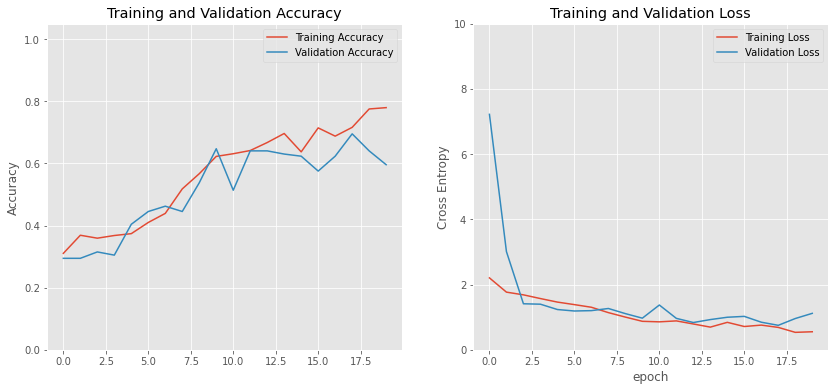

                        precision    recall  f1-score   support

                costra       0.38      0.10      0.16       118
multiples_enfermedades       0.00      0.00      0.00        18
                 oxido       0.94      0.77      0.85       124
             saludable       0.41      0.87      0.55       103

              accuracy                           0.55       363
             macro avg       0.43      0.44      0.39       363
          weighted avg       0.56      0.55      0.50       363



In [18]:
Plot_training_performance(H4, epochs, pathTeacher_img+'/arq4')
cnn4.Show_classification_report(testX, testY, batchSize, etiquetas)

### Arquitectura 5

In [12]:
inputShape_train = dataTrain_teacher.get_dataShape()
K.clear_session() 

cnn5 = ConvNeuralNetwork(inputShape_train,len(etiquetas))   # Objeto CNN
cnn5.CapaInicial(32,(3,3),'relu')                           # primer set
cnn5.AddComplemento(True,True,0.25,True,None)     
cnn5.BuildCapa(64,(3,3),2,'relu','_',0)                     # segundo set
cnn5.AddComplemento(True,True,0.25,True,None)     
cnn5.BuildCapa(128,(3,3),2,'relu','_',0)                    # tercer set
cnn5.AddComplemento(True,True,0.25,True,None)     
cnn5.BuildTopModel(True,1024,'relu','l2',0.001)       # top model
cnn5.AddComplemento(True,True,0.5,False,None)
cnn5.BuildTopModel(False,516,'relu','l2',0.001)                       
cnn5.AddComplemento(True,True,0.5,False,None)
cnn5.ModelOutput('softmax')
model5 = cnn5.__get__()
model5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 192, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 192, 192, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 64)        2

In [20]:
cnn5.Compile(0.001,"categorical_crossentropy")
epochs = 20
batchSize = 8

# Entrenamiento usando 20% de datos de TRAIN como validation (0.2) y 80% como TEST para training
H5 = cnn5.Train(dataX,dataY,0.2,epochs,batchSize)

[INFO]: Compilando el modelo...
[INFO]: Entrenando la red...
Epoch 1/20
146/146 [==============================] - 126s 856ms/step - loss: 7.7131 - accuracy: 0.3319 - val_loss: 18.2939 - val_accuracy: 0.2945
Epoch 2/20
146/146 [==============================] - 126s 860ms/step - loss: 8.0325 - accuracy: 0.4108 - val_loss: 12.2707 - val_accuracy: 0.3356
Epoch 3/20
146/146 [==============================] - 125s 858ms/step - loss: 7.0223 - accuracy: 0.4374 - val_loss: 6.5678 - val_accuracy: 0.3493
Epoch 4/20
146/146 [==============================] - 126s 862ms/step - loss: 6.1313 - accuracy: 0.4391 - val_loss: 5.9860 - val_accuracy: 0.3048
Epoch 5/20
146/146 [==============================] - 125s 859ms/step - loss: 5.5045 - accuracy: 0.4520 - val_loss: 5.6480 - val_accuracy: 0.3356
Epoch 6/20
146/146 [==============================] - 125s 859ms/step - loss: 4.9511 - accuracy: 0.5206 - val_loss: 4.9652 - val_accuracy: 0.4418
Epoch 7/20
146/146 [==============================] - 125s 85

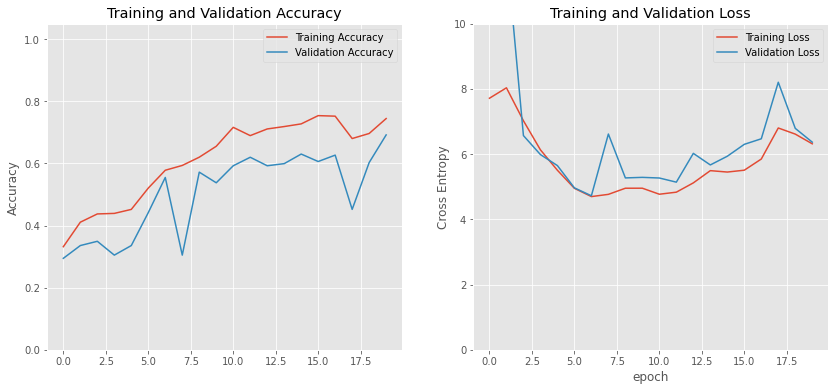

                        precision    recall  f1-score   support

                costra       0.61      0.81      0.70       118
multiples_enfermedades       0.00      0.00      0.00        18
                 oxido       0.89      0.72      0.79       124
             saludable       0.62      0.56      0.59       103

              accuracy                           0.67       363
             macro avg       0.53      0.52      0.52       363
          weighted avg       0.68      0.67      0.67       363



In [21]:
Plot_training_performance(H5, epochs, pathTeacher_img+'/arq5')
cnn5.Show_classification_report(testX, testY, batchSize, etiquetas)

### Arquitectura 6

In [13]:
inputShape_train = dataTrain_teacher.get_dataShape()
K.clear_session() 

cnn6 = ConvNeuralNetwork(inputShape_train,len(etiquetas))   # Objeto CNN
cnn6.CapaInicial(32,(3,3),'relu')                           # primer set
cnn6.AddComplemento(True,True,0.1,True,None)     
cnn6.BuildCapa(64,(3,3),1,'relu','l2',0.001)                     # segundo set
cnn6.AddComplemento(True,True,0.1,True,None)     
cnn6.BuildCapa(64,(3,3),1,'relu','l2',0.001)                     # segundo set
cnn6.AddComplemento(True,True,0.1,True,None)     
cnn6.BuildCapa(128,(3,3),1,'relu','l2',0.001)                    # tercer set
cnn6.AddComplemento(True,True,0.1,True,None)     
cnn6.BuildCapa(128,(3,3),1,'relu','l2',0.001)                    # tercer set
cnn6.AddComplemento(True,True,0.1,True,None)     
cnn6.BuildCapa(256,(3,3),1,'relu','l2',0.001)                    # tercer set
cnn6.AddComplemento(True,True,0.1,True,None)     
cnn6.BuildTopModel(True,1024,'relu','l2',0.005)                  # top model
cnn6.AddComplemento(True,True,0.3,False,None)
cnn6.BuildTopModel(False,516,'relu','l2',0.005)                       
cnn6.AddComplemento(True,True,0.3,False,None)
cnn6.ModelOutput('softmax')
model6 = cnn6.__get__()
model6.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 192, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 192, 192, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0

In [36]:
cnn6.Compile(0.001,"categorical_crossentropy")
epochs = 50
batchSize = 8

# Estructura de clase CallBacks: (earlyStopping,reduceLr,model CheckPoint, pathModelSaved)
cnn6.CallBacks(True,True,True,pathTeacher_models+'/model6.h5')

# Entrenamiento usando 20% de datos de TRAIN como validation (0.2) y 80% como TEST para training
H6 = cnn6.Train(dataX,dataY,0.2,epochs,batchSize)

[INFO]: Compilando el modelo...
[INFO]: Entrenando la red...
Epoch 1/50
146/146 [==============================] - 43s 282ms/step - loss: 12.2789 - accuracy: 0.3714 - val_loss: 12.4655 - val_accuracy: 0.0445
Epoch 2/50
146/146 [==============================] - 41s 278ms/step - loss: 9.9383 - accuracy: 0.4305 - val_loss: 10.6087 - val_accuracy: 0.0616
Epoch 3/50
146/146 [==============================] - 42s 288ms/step - loss: 7.9486 - accuracy: 0.4340 - val_loss: 10.1593 - val_accuracy: 0.2945
Epoch 4/50
146/146 [==============================] - 42s 287ms/step - loss: 6.2193 - accuracy: 0.5060 - val_loss: 6.3666 - val_accuracy: 0.4075
Epoch 5/50
146/146 [==============================] - 41s 283ms/step - loss: 4.7981 - accuracy: 0.6244 - val_loss: 4.7198 - val_accuracy: 0.5479
Epoch 6/50
146/146 [==============================] - 41s 282ms/step - loss: 3.8529 - accuracy: 0.6432 - val_loss: 4.2281 - val_accuracy: 0.4349
Epoch 7/50
146/146 [==============================] - 41s 279ms/s

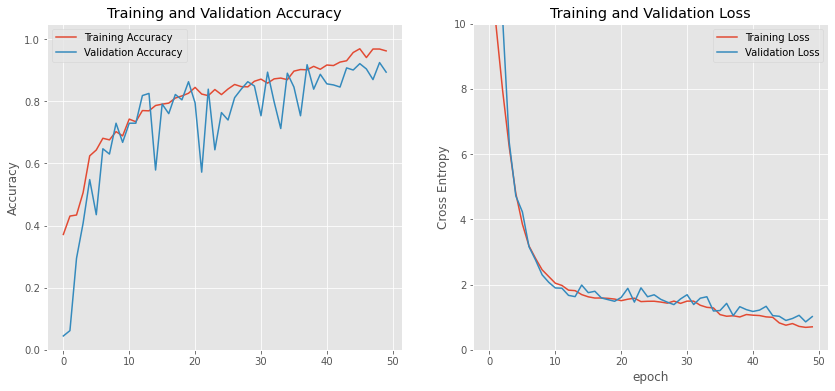

                        precision    recall  f1-score   support

                costra       0.86      0.91      0.88       118
multiples_enfermedades       0.00      0.00      0.00        18
                 oxido       0.98      0.96      0.97       124
             saludable       0.87      0.97      0.92       103

              accuracy                           0.90       363
             macro avg       0.68      0.71      0.69       363
          weighted avg       0.86      0.90      0.88       363



In [37]:
Plot_training_performance(H6, epochs, pathTeacher_img+'/arq6')
cnn6.Show_classification_report(testX, testY, batchSize, etiquetas)

In [38]:
TeacherModel_6 = load_model(pathTeacher_models+'/model6.h5')
loss, acc = TeacherModel_6.evaluate(testX, testY, verbose=2)

12/12 - 2s - loss: 0.8728 - accuracy: 0.9036


## Data Augmentation

Aunque con el paso del tiempo se logra una mejora en la precisión, en la clase multiples_enfermedades no se consigue mejorar, pero también influye que unicamente se cuenta con 18 imagenes para realizar el procesamiento por lo cual se busca mejorar esta cantidad y primero se realizará la prueba aumentando las imagenes con variaciones de las mismas usando data augmentation

Found 91 images belonging to 4 classes.
64 imagenes generadas para multiples_enfermedades


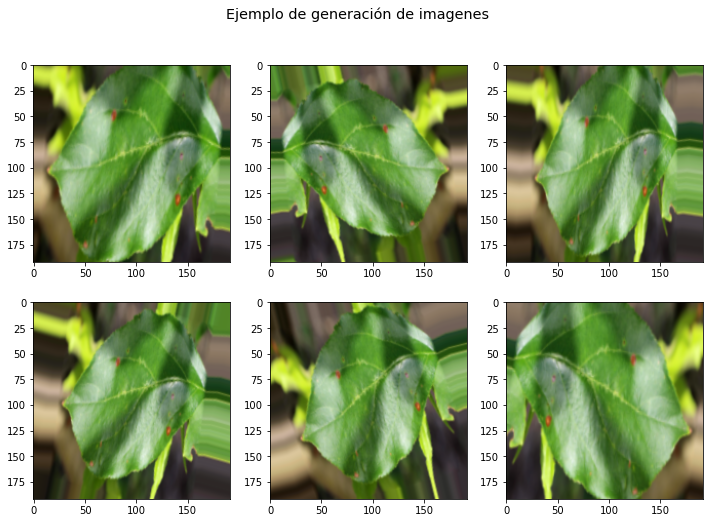

imagenes iniciales: 1458
imagenes con aumento: 1522


In [6]:
batchSize_aug = 64

#Objeto para generacion de data augmentarion para train
dataTrain_teacher_aug = PreprocData(batchSize_aug,targetSize,pathTrain)  

dataX_aug, dataY_aug = dataTrain_teacher_aug.augmentation_dataGenerator(rotation=15,
                                                                       rescale=1./255,
                                                                       shear=0.2,
                                                                       zoom=0.2,
                                                                       flip_H = True,
                                                                       classMode = 'categorical',                                                                       
                                                                       labelNames = ['no0','multiples_enfermedades','no2','no3'])

print(f"{dataX_aug.shape[0]} imagenes generadas para {etiquetas[1]}")

dataTrain_teacher_aug.GeneratorExamples_plot(dataX_aug,2,3,"Ejemplo de generación de imagenes",0)

# Adicionamos imagenes al dataset
dataX_new=np.vstack((dataX, dataX_aug))
dataY_new=np.vstack((dataY, dataY_aug))

print(f'imagenes iniciales: {dataX.shape[0]}')
print(f'imagenes con aumento: {dataY_new.shape[0]}')

### Arquitectura DataAugmentation 1

In [44]:
inputShape_train = dataTrain_teacher.get_dataShape()
K.clear_session() 

cnn_aug = ConvNeuralNetwork(inputShape_train,len(etiquetas))   # Objeto CNN
cnn_aug.CapaInicial(32,(3,3),'relu')                           # primer set
cnn_aug.AddComplemento(True,True,0.1,True,None)     
cnn_aug.BuildCapa(64,(3,3),1,'relu','l2',0.005)                     # segundo set
cnn_aug.AddComplemento(True,True,0.1,True,None)     
cnn_aug.BuildCapa(64,(3,3),1,'relu','l2',0.005)                     # segundo set
cnn_aug.AddComplemento(True,True,0.1,True,None)     
cnn_aug.BuildCapa(128,(3,3),1,'relu','l2',0.005)                    # tercer set
cnn_aug.AddComplemento(True,True,0.1,True,None)     
cnn_aug.BuildCapa(128,(3,3),1,'relu','l2',0.005)                    # tercer set
cnn_aug.AddComplemento(True,True,0.1,True,None)     
cnn_aug.BuildCapa(256,(3,3),1,'relu','l2',0.005)                    # tercer set
cnn_aug.AddComplemento(True,True,0.1,True,None)     
cnn_aug.BuildTopModel(True,1024,'relu','l2',0.01)                  # top model
cnn_aug.AddComplemento(True,True,0.3,False,None)
cnn_aug.BuildTopModel(False,512,'relu','l2',0.01)                       
cnn_aug.AddComplemento(True,True,0.3,False,None)
cnn_aug.ModelOutput('softmax')
model_aug = cnn_aug.__get__()
model_aug.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 192, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 192, 192, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0

In [ ]:
cnn_aug.Compile(0.001,"categorical_crossentropy")
epochs = 50
batchSize = 8
cnn_aug.CallBacks(True,True,True,pathTeacher_models+'/model_aug.h5')
H_aug = cnn_aug.Train(dataX_new,dataY_new,0.2,epochs,batchSize)

[INFO]: Compilando el modelo...
[INFO]: Entrenando la red...
Epoch 1/50
155/155 [==============================] - 284s 2s/step - loss: 22.6446 - accuracy: 0.3640 - val_loss: 23.6694 - val_accuracy: 0.2161
Epoch 2/50
155/155 [==============================] - 44s 285ms/step - loss: 15.8619 - accuracy: 0.4479 - val_loss: 15.8971 - val_accuracy: 0.2129
Epoch 3/50
155/155 [==============================] - 44s 286ms/step - loss: 10.7836 - accuracy: 0.5036 - val_loss: 10.3772 - val_accuracy: 0.2452
Epoch 4/50
155/155 [==============================] - 44s 285ms/step - loss: 7.4066 - accuracy: 0.6118 - val_loss: 7.8626 - val_accuracy: 0.2903
Epoch 5/50
155/155 [==============================] - 44s 283ms/step - loss: 5.7414 - accuracy: 0.6199 - val_loss: 6.4166 - val_accuracy: 0.3806
Epoch 6/50
155/155 [==============================] - 44s 285ms/step - loss: 4.5906 - accuracy: 0.6400 - val_loss: 5.0510 - val_accuracy: 0.4581
Epoch 7/50
155/155 [==============================] - 44s 282ms/s

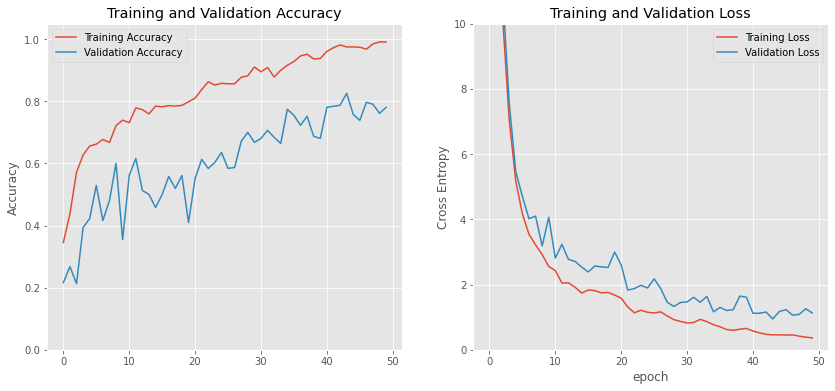

                        precision    recall  f1-score   support

                costra       0.91      0.91      0.91       118
multiples_enfermedades       0.60      0.17      0.26        18
                 oxido       0.95      0.98      0.96       124
             saludable       0.89      0.98      0.93       103

              accuracy                           0.91       363
             macro avg       0.84      0.76      0.77       363
          weighted avg       0.90      0.91      0.90       363



In [42]:
Plot_training_performance(H_aug, 50, pathTeacher_img+'/arq_aug')
cnn_aug.Show_classification_report(testX, testY, batchSize, etiquetas)

In [43]:
TeacherModel_aug = load_model(pathTeacher_models+'/model_aug.h5')
loss, acc = TeacherModel_aug.evaluate(testX, testY, verbose=2)

12/12 - 2s - loss: 0.6308 - accuracy: 0.9036


In [34]:
cnn_aug.Save(pathTeacher_models+'/model_aug.h5')
TeacherModel_aug = load_model(pathTeacher_models+'/model_aug.h5')
loss, acc = TeacherModel_aug.evaluate(testX, testY, verbose=2)

12/12 - 2s - loss: 0.6806 - accuracy: 0.9174


### Arquitectura DataAugmentation 2

In [18]:
inputShape_train = dataTrain_teacher.get_dataShape()
K.clear_session() 

cnn_aug2 = ConvNeuralNetwork(inputShape_train,len(etiquetas))   # Objeto CNN
cnn_aug2.CapaInicial(32,(3,3),'relu')                           # primer set
cnn_aug2.AddComplemento(True,True,0.25,True,(2,2))     
cnn_aug2.BuildCapa(64,(3,3),2,'relu','_',0)                     # segundo set
cnn_aug2.AddComplemento(True,True,0.25,True,(2,2))     
cnn_aug2.BuildCapa(128,(3,3),2,'relu','_',0)                    # tercer set
cnn_aug2.AddComplemento(True,True,0.25,True,(2,2))     
cnn_aug2.BuildCapa(256,(3,3),2,'relu','_',0)                    # tercer set
cnn_aug2.AddComplemento(True,True,0.25,True,(2,2))     
cnn_aug2.BuildTopModel(True,256,'relu','_',0)                  # top model
cnn_aug2.AddComplemento(True,True,0.5,False,(1,1))
cnn_aug2.BuildTopModel(False,128,'relu','_',0)                  # top model
cnn_aug2.AddComplemento(True,True,0.5,False,(1,1))
cnn_aug2.ModelOutput('softmax')
model_aug2 = cnn_aug2.__get__()

In [19]:
cnn_aug2.Compile(0.001,"categorical_crossentropy")
epochs = 50
batchSize = 16
cnn_aug2.CallBacks(True,True,True,pathTeacher_models+'/model_aug2')
H_aug2 = cnn_aug2.Train(dataX_new,dataY_new,0.2,epochs,batchSize)

[INFO]: Compilando el modelo...
[INFO]: Entrenando la red...
Epoch 1/50
77/77 [==============================] - 74s 944ms/step - loss: 2.1027 - accuracy: 0.3016 - val_loss: 2.8079 - val_accuracy: 0.2426
INFO:tensorflow:Assets written to: models/teacherModels/models\model_aug2\assets
Epoch 2/50
77/77 [==============================] - 74s 960ms/step - loss: 1.7984 - accuracy: 0.3237 - val_loss: 2.4579 - val_accuracy: 0.2361
INFO:tensorflow:Assets written to: models/teacherModels/models\model_aug2\assets
Epoch 3/50
77/77 [==============================] - 75s 980ms/step - loss: 1.5918 - accuracy: 0.3591 - val_loss: 3.5348 - val_accuracy: 0.2361
Epoch 4/50
77/77 [==============================] - 80s 1s/step - loss: 1.3816 - accuracy: 0.4445 - val_loss: 2.7488 - val_accuracy: 0.2361
Epoch 5/50
77/77 [==============================] - 81s 1s/step - loss: 1.0822 - accuracy: 0.5768 - val_loss: 4.1404 - val_accuracy: 0.2361
Epoch 6/50
77/77 [==============================] - 80s 1s/step - lo

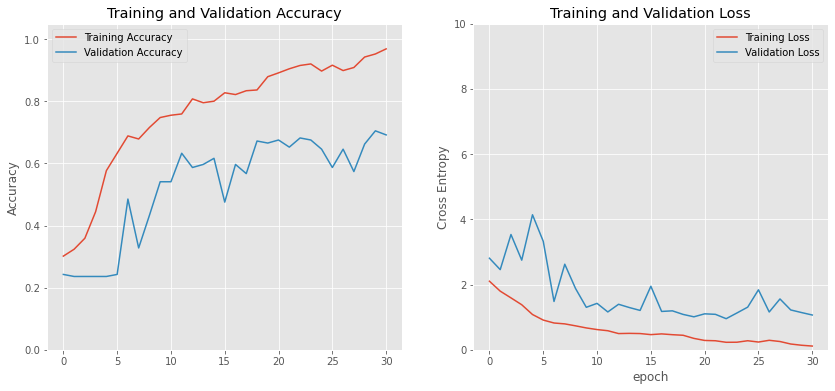

                        precision    recall  f1-score   support

                costra       0.83      0.89      0.86       118
multiples_enfermedades       0.20      0.06      0.09        18
                 oxido       0.96      0.97      0.96       124
             saludable       0.86      0.88      0.87       103

              accuracy                           0.87       363
             macro avg       0.71      0.70      0.69       363
          weighted avg       0.85      0.87      0.86       363



In [20]:
Plot_training_performance(H_aug2, 31, pathTeacher_img+'/arq_aug2')
cnn_aug2.Show_classification_report(testX, testY, batchSize, etiquetas)